In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from glob import glob
import os
import sys
sys.path.insert(0,"/study/mrphys/skunkworks/kk/mriUnet")
import unet
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import KFold as kf
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import h5py
import shutil

allImages = sorted(glob('/study/mrphys/skunkworks/kk/pred/denoised_*.npy', recursive=True))
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
noisyPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/acc_2min/C.h5' for p in samples]

def getComplexSlices(path):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.abs(np.array(image['real']+image['real']*1j)).max()
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    return imagestackReal+imagestackImag*1j, normScale

In [2]:
try:
    os.mkdir('/local/kk/denoised')
except:
    pass

In [25]:
for i, imgIndex in tqdm(enumerate(range(len(allImages)))):
    
    name = sorted(glob("/study/mrphys/skunkworks/training_data//mover01/*/", recursive=True))[imgIndex].split('/')[-2]
    
    if os.path.exists(f'/local/kk/denoised/{name}/C.h5'):
        file_stats = os.stat(f'/local/kk/denoised/{name}/C.h5')
        file_size_gb = file_stats.st_size / (1024 * 1024 * 1024)
        if file_size_gb>=2: #finished file
            print(f'{name} passed!')
            continue
    
    try:
        os.mkdir(f'/local/kk/denoised/{name}')
    except:
        pass
    
    for file in ['basis.arma','gmpnrage_parameters.txt','mpnrage_t1fitting_parameters.txt']:
                
        shutil.copy(f'/study/mrphys/skunkworks/kk/modelfitting/{file}', f'/local/kk/denoised/{name}/{file}')

    with h5py.File(f'/local/kk/denoised/{name}/C.h5','w') as f:
        pred = np.load(f'pred/denoised_{i}.npy')
        
        #pad the remaining pca
        zero = np.zeros([6,256,256,256]).astype(pred.dtype)
        pred = np.concatenate([pred, zero])
        
        temp = pred.astype(np.dtype([('real','f'),('imag','f')]))
        temp['imag'] = pred.imag
        pred = temp
        grp = f.create_group('Images')
        for n in range(16):     
            grp.create_dataset('C_000_0'+ str(n).zfill(2), data=pred[n])
            
    del pred

0it [00:00, ?it/s]/tmp/ipykernel_479961/1437289096.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  temp = pred.astype(np.dtype([('real','f'),('imag','f')]))
65it [05:39,  5.23s/it]


In [ ]:
def getComplexSlices(path):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.abs(np.array(image['real']+image['real']*1j)).max()
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    return imagestackReal+imagestackImag*1j, normScale

In [4]:
allImages = sorted(glob("/study/mrphys/skunkworks/training_data//mover01/*/", recursive=True))[0:40]

In [5]:
def getComplexSlices(path):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.abs(np.array(image['real']+image['real']*1j)).max()
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    return imagestackReal+imagestackImag*1j, normScale

class mriNoisyDataset(Dataset):
    def __init__(self, sample):
        self.originalPath = []
        self.accelPath = [] 

        allImages = sorted(glob("/study/mrphys/skunkworks/training_data//mover01/*/", recursive=True))[0:40]
        folderName  = allImages[sample]
        self.accelPath = folderName +'processed_data/acc_2min/C.h5'
        self.accelFile, self.scale = getComplexSlices(self.accelPath)

    def __getitem__(self, index):
        if index<256:
            return self.accelFile[:,index,:,:]
        elif index<512:
            index = index-256
            return self.accelFile[:,:,index,:]
        else:
            index = index-512
            return self.accelFile[:,:,:,index]
        
    def __len__(self):
        return 768

In [12]:
def predict(model, dataset, device = 5):
    model.eval()
    model.to(device)
    X = []
    Y = []
    Z = []
    for i, noisy in enumerate(dataset):
        noisy = torch.tensor(noisy).to(device).unsqueeze(0)
        with torch.no_grad():
            p = model(noisy).cpu().numpy() * dataset.scale
            if i<256:
                X.append(p)
            elif i<512:
                Y.append(p)
            else:
                Z.append(p)
                
    return np.vstack(X).transpose(1,0,2,3), np.vstack(Y).transpose(1,2,0,3), np.vstack(Z).transpose(1,2,3,0)

In [13]:
folds = 5
kfsplitter = kf(n_splits=folds, shuffle=True, random_state=69420)
for i, (train_index, test_index) in enumerate(kfsplitter.split(allImages)):
    fold = i+1
    model = unet.UNet(
        10,
        10,
        f_maps=32,
        layer_order=['separable convolution', 'relu'],
        depth=4,
        layer_growth=2.0,
        residual=True,
        complex_input=True,
        complex_kernel=True,
        ndims=2,
        padding=1
    )
    name = f'fullDenoiser_{fold}'
    model.load_state_dict(torch.load(f'/study/mrphys/skunkworks/kk/outputs/{name}/weights/{name}_BEST.pth'))
    for index in tqdm(test_index):
        dataset = mriNoisyDataset(index)
        X, Y, Z = predict(model, dataset)
        pred = (X+Y+Z)/3
        np.save(f'pred/denoised_{index}.npy',np.array(pred))

Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]
Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]
Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]
Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]
Crop amount [(-4, -4, -4, -4), (-16, -16, -16, -16), (-40, -40, -40, -40)]


  0%|                                                                                             | 0/2 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [6]:
def getComplexSlices(path):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.abs(np.array(image['real']+image['imag']*1j)).max()
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    return imagestackReal+imagestackImag*1j, normScale

T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
noisyPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/acc_2min/C.h5' for p in samples]
for i, x in tqdm(enumerate(noisyPath)):
    if not i in [0,1,2,3]:
        continue
    d = f'/study/mrphys/skunkworks/kk/pred/denoised_{i}.npy'
    array = np.load(d)
    _, normScale = getComplexSlices(x)
    array *= normScale
    np.save(d, array)

65it [00:32,  2.03it/s]


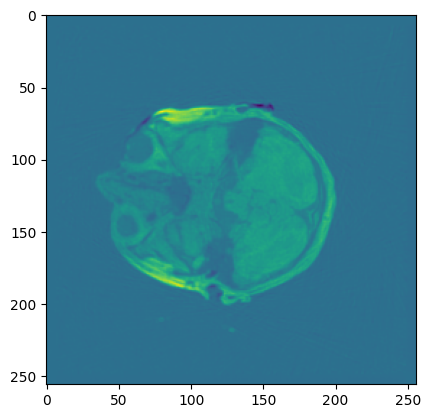

In [21]:
n = 0
T1path = sorted(glob('/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii'))
samples = [p.split('/')[6] for p in T1path]
noisyPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/acc_2min/C.h5' for p in samples]
def getComplexSlices(path):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.abs(np.array(image['real']+image['imag']*1j)).max()
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    return imagestackReal+imagestackImag*1j, normScale
_, normScale = getComplexSlices(noisyPath[0])
pred = np.load(f'pred/denoised_{n}.npy')[0,100]
plt.imshow((pred*normScale).real)

In [5]:
def readh5(path):
    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(16):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
        imagestackReal = np.array(imagestackReal)
        imagestackImag = np.array(imagestackImag)
        
    return imagestackReal+imagestackImag*1j

In [37]:
noisy = readh5('/study/mrphys/skunkworks/training_data/mover01/M001/processed_data/acc_2min/C.h5')
cleaned = readh5('/study/mrphys/skunkworks/training_data/mover01/M001/processed_data/C.h5')
pred = np.load(f'pred/denoised_0.npy')

In [38]:
normscale = np.max(np.abs(noisy[0]))
normscale_2 = np.max(np.abs(cleaned[0]))

In [34]:
np.max(pred[0]), np.min(pred[0])

((1.1670165-0.16786133j), (0.14361267+0.04542937j))

In [36]:
np.max(noisy[0]/normscale), np.min(noisy[0]/normscale)

((0.56776685-0.05845145j), (-0.9577573+0.16470063j))

In [39]:
np.max(cleaned[0]/normscale_2), np.min(cleaned[0]/normscale_2)

((0.5685225-0.13218488j), (-0.9779276+0.18666382j))

In [14]:
np.mean(denoised[0])

(46476.242+139.32108j)

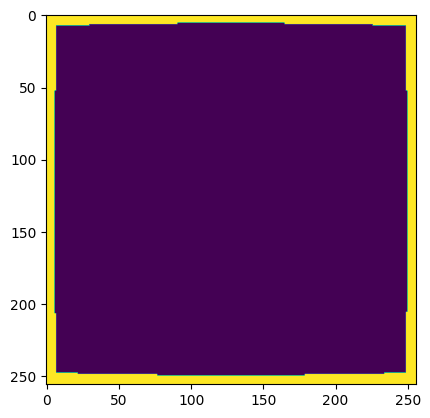

In [12]:
plt.imshow(noisy[0,100]==0)

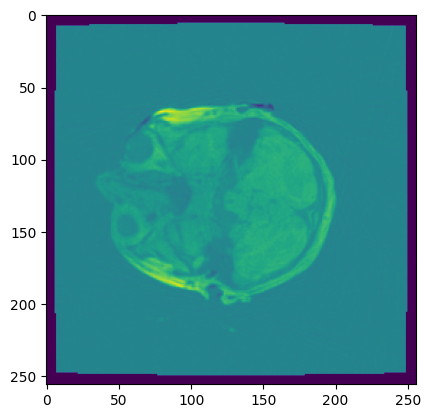

In [9]:
plt.imshow(denoised[0,100].real)

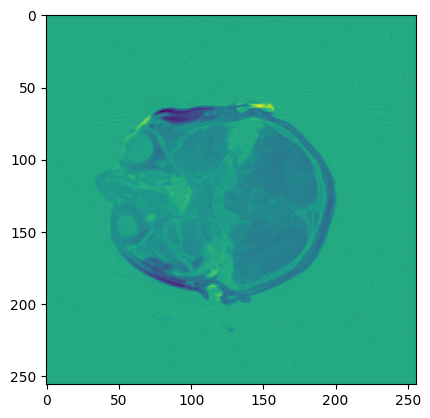

In [7]:
plt.imshow(acc[0,100].real)

In [ ]:
from subprocess import call
import os
import time
for file in sorted(os.listdir('/local/kk/denoised/')):
    if "." in file:
        continue
    t0 = time.time()
    print(f"Start processing {file}")
    status = call("nice bash /study/mrphys/skunkworks/kk/modelfitting/modelfitting.sh",cwd=f"/local/kk/denoised/{file}",shell=True)
    print(f"Completed file {file} with exit status {status}")
    eta = round((time.time()-t0)/60, 2)
    print(f"ETA = {eta}")

Start processing M001
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for SIGNAL_FITTING are: 
fit_type is 0
mask_background is 0
num_iter is 20
inital_lambda is 0.001
lambda_v is 3.16228
num_passes is 4
multipass_fit_type is 0
num_fit_slices 8
robust_init is 1
append_out

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M004 with exit status 0
ETA = 25.22
Start processing M005
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M007 with exit status 0
ETA = 14.01
Start processing M008
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M010 with exit status 0
ETA = 14.14
Start processing M011
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M013 with exit status 0
ETA = 13.65
Start processing M014
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M016 with exit status 0
ETA = 13.58
Start processing M017
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po

min_kernel = 2.91711e-07
About to export smoothed inversion efficiency
Fitting data for pass 2
Np = 1
Nf = 2
Fitting data for pass 3
Np = 1
Nf = 2
Completed file M019 with exit status 0
ETA = 14.06
Start processing M020
/home/kecskemeti/local/bin/fit_signal -t1fit_mpnrage_vfa -pca  -fit_signal -t1fit_mpnrage_vfa -fit_frequency 20 -fitting_num_slices 8 -threshold_mask 0.002 -central_blob_mask -fsize_mask 2 -fitting_num_passes 4 -fsize_b1 7 -fsize_inv_eff 9 -nlm_sigma 900 -nlm_width 9 -robust_init
inside CHANGE_OF_BASIS(void)
inside SIGFIT_WRAPPER::parse_commandline(int numarg, char **pstring)
parameters for SIGFIT_WRAPPER are: 
fit_type is 0
pca_flag is 1
pca_rank is 16
input_type is 0
input_data_type is 3
num_iter is 1
tv_pca is 0
inside MASK::parse_commandline(int numarg, char **pstring)
threshold_mask is: 0.002
fsize_mask is: 2
gsize_mask is: 0
ssize_mask is: 0
central_blob is: 1
threshold_only is: 0
inside SIGNAL_FITTING::parse_commandline(int numarg, char **pstring)
parameters for 

reading C_000_001
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_002
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_003
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_004
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_005
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_006
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_007
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_008
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_009
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_010
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_011
Dataspace has 16777216 points while array has 0
Resizing input array
reading C_000_012
Dataspace has 16777216 po